In [23]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


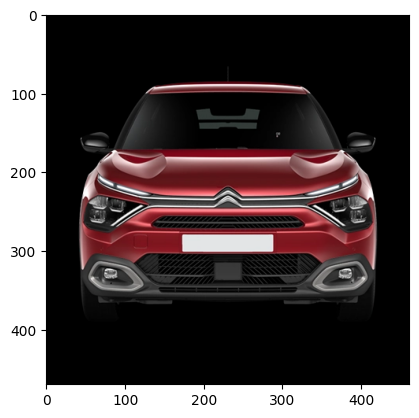

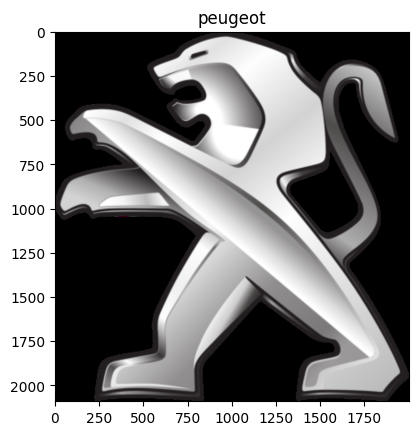

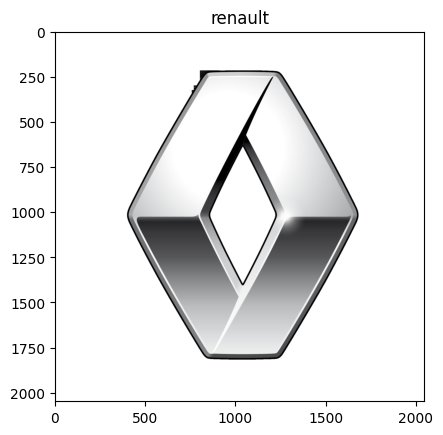

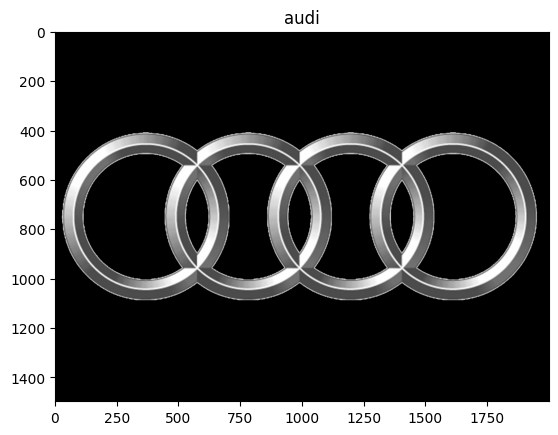

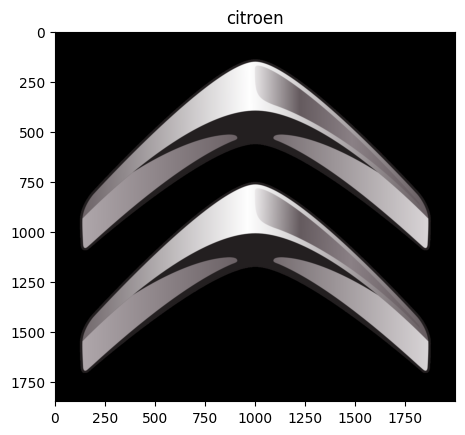

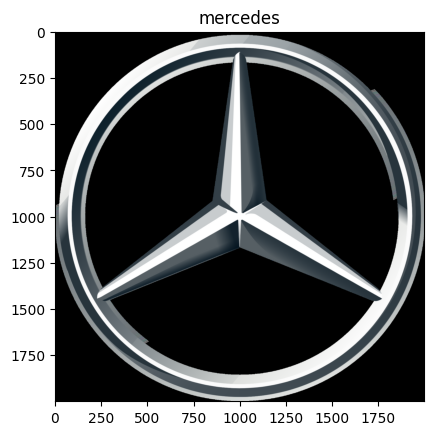

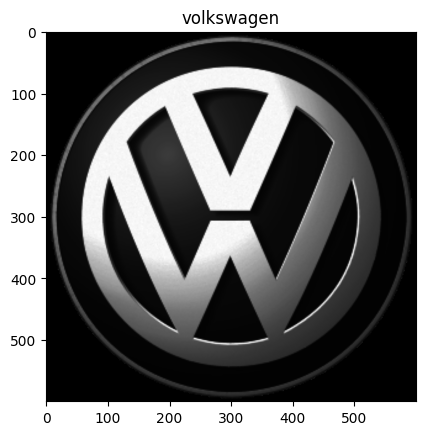

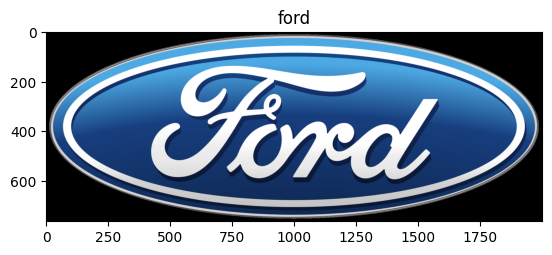

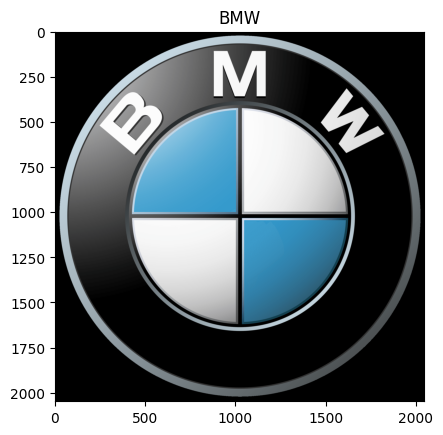

In [24]:
def read_image(file_path):
    return cv2.imread(file_path) #lecture de l'image

#bibliothèque de logos pour lire les images et renvoyer les noms des logos
logos = { 
    "peugeot": read_image("images/logos/logo_peugeot.png"),
    "renault": read_image("images/logos/logo_renault.png"),
    "audi": read_image("images/logos/logo_audi.png"),
    "citroen": read_image("images/logos/logo_citroen.png"),
    "mercedes": read_image("images/logos/logo_mercedes.png"),
    "volkswagen": read_image("images/logos/logo_volkswagen.png"),
    "ford": read_image("images/logos/logo_ford.png"),
    "BMW": read_image("images/logos/logo_BMW.png")
}



# lecture de l'image de test
test_image = read_image("images/Voitures/voiture14.png")
test_image = cv2.cvtColor(test_image, cv2.COLOR_RGB2BGR)
plt.imshow(test_image)
plt.show()

#affichage des logos
for logo_name, logo_image in logos.items():
    logo_image = cv2.cvtColor(logo_image, cv2.COLOR_RGB2BGR)
    plt.imshow(logo_image)
    plt.title(logo_name)
    plt.show()



In [25]:
def niv_gris(image):
    if len(image.shape) == 3: # si l'image est en couleur alors on la convertit en niveau de gris
        img_gris = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:                   # sinon on la laisse en niveau de gris, cela permet de ne pas convertir une image déjà en niveau de gris et provoquer des erreurs
        img_gris = image
    return img_gris


def ORB(img, n_keypoints=5000):
    orb = cv2.ORB_create(n_keypoints) # augmentation du nombre de points afin d'essayer de trouver plus de points de correspondance et rendre le programme plus précis 
    img_gris = niv_gris(img)
    points, descripteursImg = orb.detectAndCompute(img_gris, None)
    return points, descripteursImg

def SIFT(img, n_features=5000):
    sift = cv2.SIFT_create(n_features) # augmentation du nombre de features afin d'essayer de trouver plus de points de correspondance et rendre le programme plus précis 
    img_gris = niv_gris(img)
    points, descripteursImg = sift.detectAndCompute(img_gris, None)
    return points, descripteursImg

def compa_force_brute_SIFT(img1, img2, ratio_lowe=0.75):
    algoBF = cv2.BFMatcher()
    points1, descripteurs_img1 = SIFT(img1)
    points2, descripteurs_img2 = SIFT(img2)
    paires_corresp = algoBF.knnMatch(descripteurs_img1, descripteurs_img2, k=2)
    bonnes_correspondances = []
    for m,n in paires_corresp:
        if m.distance < ratio_lowe*n.distance:  # ratio de lowe pour comparer les distances entre les points plus éfficace que comparer les 25 premiers points (découverte sur internet)
            bonnes_correspondances.append([m])
    return bonnes_correspondances

def compa_force_brute_ORB(img1, img2, ratio_lowe=0.75):
    algoBF = cv2.BFMatcher()
    points1, descripteurs_img1 = ORB(img1)
    points2, descripteurs_img2 = ORB(img2)
    paires_corresp = algoBF.knnMatch(descripteurs_img1, descripteurs_img2, k=2)
    bonnes_correspondances = [] 
    for m,n in paires_corresp:
        if m.distance < ratio_lowe*n.distance: # ratio de lowe pour comparer les distances entre les points plus éfficace que comparer les 25 premiers points (découverte sur internet)
            bonnes_correspondances.append([m])
    return bonnes_correspondances

def compa_FLANN_SIFT(img1, img2, lowe_ratio=0.6):
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params,search_params) # utilisation de FLANN plus récent que BFMatcher découverte sur internet
    points1, descripteurs_img1 = SIFT(img1)
    points2, descripteurs_img2 = SIFT(img2)
    paires_corresp = flann.knnMatch(descripteurs_img1, descripteurs_img2, k=2) # flann plutot que bfmatcher car plus récent et plus rapide (découverte sur internet)
    bonnes_correspondances = []
    for m,n in paires_corresp:
        if m.distance < lowe_ratio*n.distance:  # ratio de lowe pour comparer les distances entre les points plus éfficace que comparer les 25 premiers points (découverte sur internet)
            bonnes_correspondances.append(m)
    return bonnes_correspondances, points1, points2

# Preprocess l'image pour la rendre plus facile à comparer
def preprocess_image(img):
    #img = cv2.resize(img, (500, 500)) # redimensionner l'image pas utiliser car déforme les logos
    img = cv2.GaussianBlur(img, (5, 5), 0) # flou gaussien
    img = niv_gris(img) # convertir en niveau de gris
    _, img = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU) # Seuillage de l'image
    return img

# utilisation d'AKAZE pour comparer les logos (méthode plus récente découverte sur internet)
def AKAZE(img):
    akaze = cv2.AKAZE_create()
    img_gris = niv_gris(img)
    points, descripteursImg = akaze.detectAndCompute(img_gris, None)
    return points, descripteursImg

def compa_force_brute(img1, img2, method, ratio_lowe=0.75):
    algoBF = cv2.BFMatcher()
    points1, descripteurs_img1 = method(img1)
    points2, descripteurs_img2 = method(img2)
    paires_corresp = algoBF.knnMatch(descripteurs_img1, descripteurs_img2, k=2)
    bonnes_correspondances = []
    for m,n in paires_corresp:
        if m.distance < ratio_lowe*n.distance:
            bonnes_correspondances.append([m])
    return bonnes_correspondances, points1, points2


def compare_logos(img_voiture):
    methods = [ORB, SIFT, AKAZE]
    scores = {method.__name__: {logo_name: 0 for logo_name in logos.keys()} for method in methods}
    combined_scores = {logo_name: 0 for logo_name in logos.keys()}
    matches = {method.__name__: {logo_name: [] for logo_name in logos.keys()} for method in methods}
    keypoints1 = {method.__name__: {logo_name: [] for logo_name in logos.keys()} for method in methods}
    keypoints2 = {method.__name__: {logo_name: [] for logo_name in logos.keys()} for method in methods}

    for logo_name, logo_image in logos.items():
        # Preprocess 
        img_voiture = preprocess_image(img_voiture)
        logo_image = preprocess_image(logo_image)

        # ORB , SIFT , AKAZE pour comparer les logos
        for method in methods:
            match, kp1, kp2 = compa_force_brute(img_voiture, logo_image, method)
            flat_match = [item for sublist in match for item in sublist]

            # calcule le score de chaque logo
            score = len([m for m in flat_match if m.distance < 0.75 * np.mean([m.distance for m in flat_match])])
            scores[method.__name__][logo_name] += score


            # Stock les correspondances et les keypoints
            matches[method.__name__][logo_name].extend(flat_match)
            keypoints1[method.__name__][logo_name].extend(kp1)
            keypoints2[method.__name__][logo_name].extend(kp2)
            
    # initialise le score combiné
    combined_scores = {logo_name: 0 for logo_name in logos.keys()}

    # normalise les scores
    for method in scores:
        max_score = max(scores[method].values())
        for logo_name in scores[method]:
            scores[method][logo_name] /= max_score
            combined_scores[logo_name] += scores[method][logo_name]

     # choisi le logo avec le plus haut score pour chaque méthode
    meilleur_logos = {method: max(scores[method], key=scores[method].get) for method in scores}
    meilleur_logo_combined = max(combined_scores, key=combined_scores.get)

    # renvoie le nom du logo
    return meilleur_logos, meilleur_logo_combined, scores, combined_scores, matches, keypoints1, keypoints2


def show_matches(img_voiture, logo_image, matches, keypoints1, keypoints2):
    # dessine les correspondances sur les images
    img_voiture_matches = cv2.drawMatches(
        img_voiture,
        keypoints1,
        logo_image,
        keypoints2,
        matches,
        None,
        matchColor=(0, 255, 0),
        singlePointColor=(0, 0, 255),
        flags=cv2.DrawMatchesFlags_DEFAULT,
    )

    # affiche les images
    plt.imshow(cv2.cvtColor(img_voiture_matches, cv2.COLOR_BGR2RGB))
    plt.show()



In [26]:
# affiche les correspondances pour chaque méthode
meilleur_logos, meilleur_logo_combined, scores, combined_scores, matches, keypoints1, keypoints2 = compare_logos(test_image)
print(meilleur_logos)
print("Meilleur logo avec score combiné :", meilleur_logo_combined)

{'ORB': 'BMW', 'SIFT': 'mercedes', 'AKAZE': 'BMW'}
Meilleur logo avec score combiné : BMW


In [27]:

meilleur_logos, meilleur_logo_combined, scores, combined_scores, matches, keypoints1, keypoints2 = compare_logos(test_image)

# affiche les scores combinés pour chaque logo
print("Scores combinés :")
for logo_name, score in combined_scores.items():
    print(f"{logo_name} : {score}")

# affiche les scores pour chaque logo par méthode
print("Scores par méthode :")
for method, logos_scores in scores.items():
    print(f"\nMéthode : {method}")
    for logo_name, score in logos_scores.items():
        print(f"{logo_name} : {score}")

Scores combinés :
peugeot : 1.3492063492063493
renault : 0.7301587301587301
audi : 0.36507936507936506
citroen : 0.5714285714285714
mercedes : 1.9285714285714286
volkswagen : 1.880952380952381
ford : 1.0793650793650793
BMW : 2.111111111111111
Scores par méthode :

Méthode : ORB
peugeot : 0.5714285714285714
renault : 0.2857142857142857
audi : 0.14285714285714285
citroen : 0.5714285714285714
mercedes : 0.42857142857142855
volkswagen : 0.7142857142857143
ford : 0.8571428571428571
BMW : 1.0

Méthode : SIFT
peugeot : 0.7777777777777778
renault : 0.4444444444444444
audi : 0.2222222222222222
citroen : 0.0
mercedes : 1.0
volkswagen : 0.6666666666666666
ford : 0.2222222222222222
BMW : 0.1111111111111111

Méthode : AKAZE
peugeot : 0.0
renault : 0.0
audi : 0.0
citroen : 0.0
mercedes : 0.5
volkswagen : 0.5
ford : 0.0
BMW : 1.0


In [28]:
def main():
    # demande à l'utilisateur si il veut comparer une image à la base de données de logos ou faire une comparaison entre une image et un logo
    choice = input("Voulez-vous comparer une image à la base de données de logos (1) ou faire une comparaison entre une image et un logo (2) ? ")

    # si l'utilisateur veut comparer une image à la base de données de logos
    if choice == '1':
        # demande à l'utilisateur le chemin de l'image qu'il veut comparer
        image_path = input("Veuillez entrer le chemin de l'image de la voiture que vous voulez comparer : ")
        # lit l'image
        test_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        # compare l'image à la base de données de logos
        best_logos, best_logo_combined, scores, combined_scores, matches, keypoints1, keypoints2 = compare_logos(test_image)

        # affiche les correspondances pour chaque méthode
        print("Meilleur logo par méthode :")
        for method, logo in best_logos.items():
            print(f"Méthode: {method}, Logo: {logo}")

        # affiche le meilleur logo avec le score combiné
        print("Meilleur logo avec score combiné :", best_logo_combined)

        # affiche les scores combinés pour chaque logo
        print("Scores combinés :")
        for logo_name, score in combined_scores.items():
            print(f"{logo_name} : {score}")

        # affiche les scores pour chaque logo par méthode
        print("Scores par méthode :")
        for method, logos_scores in scores.items():
            print(f"\nMéthode : {method}")
            for logo_name, score in logos_scores.items():
                print(f"{logo_name} : {score}")

    # si l'utilisateur veut comparer une image et un logo
    elif choice == '2':
        # demande à l'utilisateur le chemin de l'image et du logo qu'il veut comparer
        image_path = input("Veuillez entrer le chemin de l'image de la voiture que vous voulez comparer : ")
        logo_path = input("Veuillez entrer le chemin du logo que vous voulez comparer : ")

        # lit l'image et le logo
        test_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        logo_image = cv2.imread(logo_path, cv2.IMREAD_GRAYSCALE)


        # compare l'image et le logo avec la méthode flann et sift
        matches, kp1, kp2 = compa_FLANN_SIFT(test_image, logo_image)

         # dessine les correspondances sur les images
        img_matches = cv2.drawMatches(test_image, kp1, logo_image, kp2, matches, None, matchesThickness=2)
        plt.imshow(img_matches)
        plt.show()

    # si l'utilisateur entre un choix invalide   
    else:
        print("Choix invalide. Veuillez entrer 1 ou 2.")

# lance le programme
if __name__ == "__main__":
    main()

Choix invalide. Veuillez entrer 1 ou 2.
